In [303]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as dset

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [304]:
n_epochs = 200
batch_size = 64
lr = 2e-4
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 64
channels = 3
sample_interval=400
lam1 = 1e-1
lam2 = 0
sample_pixels = sorted(np.random.randint(low = 0, high = img_size*img_size*3, size = (7500,)))

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [305]:
dataroot = "resized_data_bayc_no_background"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [306]:
samples = 6000
image_samples = np.zeros((samples, img_size*img_size*3))
for i in range(0, samples):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, _ = dataset[sample_idx]
    flat = torch.flatten(img).detach().numpy()
    image_samples[i] = flat
image_samples_apes = image_samples.T[sample_pixels]

In [307]:
mean_apes = np.mean(image_samples_apes, axis = 1)
cov_apes = np.cov(image_samples_apes) + 0.0001*np.identity(len(sample_pixels)) 
dist_apes = mvn(mean_apes, cov_apes)

In [308]:
dataroot = "resized_data_unicorns"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [309]:
samples = 2000
image_samples = np.zeros((samples, img_size*img_size*3))
for i in range(0, samples):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, _ = dataset[sample_idx]
    flat = torch.flatten(img).detach().numpy()
    image_samples[i] = flat
image_samples_unicorns = image_samples.T[sample_pixels]

In [310]:
mean_unicorns = np.mean(image_samples_unicorns, axis = 1)
cov_unicorns = np.cov(image_samples_unicorns) + 0.0001*np.identity(len(sample_pixels)) 
dist_unicorns = mvn(mean_unicorns, cov_unicorns)

In [319]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    
    def regularization(self, gen_imgs):
        
        result1 = 0
        result2 = 0
        sample_images = sorted(np.random.randint(low = 0, high = len(gen_imgs), size = (5,)))
        """
        for i in sample_images:
            out = gen_imgs[i]
            sampled = torch.flatten(out).detach().numpy()[sample_pixels]
            result += dist_apes.logpdf(sampled)
        return result/len(sample_images)
        """
        for i in sample_images:
            img = gen_imgs[i]
            flat = torch.flatten(img).numpy()[sample_pixels]
            diff1 = (image_samples_apes.T - flat).T
            #diff2 =  (image_samples_unicorns.T - flat).T
            result1 += -np.log(np.min(np.linalg.norm(diff1, axis=0)))
            #result2 += -np.log(np.min(np.linalg.norm(diff2, axis=0)))
        return lam1*result1/len(sample_images) + lam2*result2/len(sample_images)
        

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [320]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [321]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [322]:
dataroot = "resized_data_bayc_no_background"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [323]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [324]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [325]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) + generator.regularization(gen_imgs.data)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(dataloader) + i

        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:25], "gen_bayc_no_background_regularization/%d.png" % batches_done, nrow=5, normalize=True)    

[Epoch 0/200] [Batch 0/157] [D loss: 0.682002] [G loss: 0.249789]
[Epoch 2/200] [Batch 86/157] [D loss: 0.559372] [G loss: 0.494357]
[Epoch 5/200] [Batch 15/157] [D loss: 1.080021] [G loss: -0.163397]
[Epoch 7/200] [Batch 101/157] [D loss: 0.728966] [G loss: 0.007692]
[Epoch 10/200] [Batch 30/157] [D loss: 0.483900] [G loss: 0.491957]
[Epoch 12/200] [Batch 116/157] [D loss: 0.529948] [G loss: 0.317327]
[Epoch 15/200] [Batch 45/157] [D loss: 0.531885] [G loss: 1.013589]
[Epoch 17/200] [Batch 131/157] [D loss: 0.356082] [G loss: 0.881952]
[Epoch 20/200] [Batch 60/157] [D loss: 0.506100] [G loss: 0.423422]
[Epoch 22/200] [Batch 146/157] [D loss: 0.422488] [G loss: 0.909843]
[Epoch 25/200] [Batch 75/157] [D loss: 0.535173] [G loss: 1.816017]
[Epoch 28/200] [Batch 4/157] [D loss: 0.335708] [G loss: 0.910477]
[Epoch 30/200] [Batch 90/157] [D loss: 0.266240] [G loss: 1.988096]


KeyboardInterrupt: 

In [326]:
z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

In [327]:
gen_imgs = generator(z)

In [332]:
print(gen_imgs[0].item)

tensor([[[-0.7904, -0.6573,  0.3974,  ...,  0.5347, -0.5327, -0.8168],
         [-0.5625,  0.9399,  0.6861,  ...,  0.8819,  0.9093, -0.5398],
         [ 0.5648,  0.9744,  0.9252,  ...,  0.7882,  0.9048,  0.4699],
         ...,
         [ 0.6476,  0.9711,  0.9495,  ...,  0.9480,  0.9678,  0.6084],
         [-0.4587,  0.8278,  0.8059,  ...,  0.8742,  0.8819, -0.1922],
         [-0.8561, -0.5113,  0.4948,  ...,  0.6840, -0.3853, -0.9199]],

        [[-0.9459, -0.5451,  0.4498,  ...,  0.4922, -0.7633, -0.7947],
         [-0.6085,  0.9574,  0.9697,  ...,  0.9174,  0.9552, -0.3060],
         [ 0.5307,  0.9194,  0.9736,  ...,  0.9122,  0.9068,  0.4191],
         ...,
         [-0.0202,  0.9546,  0.9521,  ...,  0.9168,  0.9373,  0.4520],
         [-0.3109,  0.9855,  0.8367,  ...,  0.9176,  0.9066, -0.4933],
         [-0.7862, -0.5688,  0.3503,  ...,  0.2813, -0.6560, -0.7940]],

        [[-0.9396, -0.6441,  0.2045,  ...,  0.2936, -0.7240, -0.7618],
         [-0.7406,  0.9648,  0.8710,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


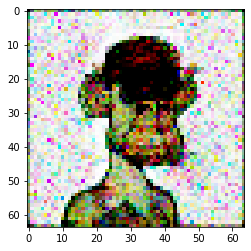

In [337]:
plt.imshow(  gen_imgs.data[6].permute(1, 2, 0)  )

In [339]:
generator.regularization(gen_imgs.data)

-0.3028939561341505